# Multi-Seed Analysis

In [1]:
import sys
import os

sys.path.append("../")
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mirrorbench.io.paths import Paths
from mirrorbench.report import generate_json_report

In [3]:
def get_report_for_run(run_id: str):
    paths = Paths.default()
    summary = paths.load_run_summary(run_id)
    report = generate_json_report(summary)
    return report

def get_run_metric_list(run_id: str, metric_name: str):
    report = get_report_for_run(run_id)
    mean_list = []
    ci_list = []
    for agg in report["aggregates"]:
        if agg["metric_name"] == metric_name:
            mean_list.append(agg["mean"])
            ci_list.append(agg["confidence_interval"])
    return mean_list, ci_list

In [4]:
proxy_to_run_map = {
    "gpt-4o": "chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge-5seed",
    "claude-4-sonnet": "chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge-5seed",
    "gemini-2.5-pro": "chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge-5seed"
}
metric_to_key = {
    "metric:judge/gteval": "GTEval (↑)",
    'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',
    'metric:judge/rubric_and_reason': 'RNR (↑)'
}

proxy_to_metric_map = {}
for proxy, run_id in proxy_to_run_map.items():
    metric_dict = {}
    for metric_name, key in metric_to_key.items():
        mean_list, ci_list = get_run_metric_list(run_id, metric_name)
        metric_dict[key] = {
            "mean": mean_list,
            "ci": ci_list
        }
    proxy_to_metric_map[proxy] = metric_dict

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_34228/3551102444.py:8: SyntaxWarning: invalid escape sequence '\D'
  'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',


In [5]:
proxy_to_metric_map

{'gpt-4o': {'GTEval (↑)': {'mean': [0.5543589743589744,
    0.5541025641025641,
    0.5538461538461539,
    0.5541025641025641,
    0.5543589743589744],
   'ci': [0.04209326746672614,
    0.04206059476114572,
    0.042015783231297746,
    0.04206059476114572,
    0.04209326746672614]},
  'PI $\\Delta w$ (↑)': {'mean': [0.5025641025641026,
    0.49914529914529915,
    0.5008547008547009,
    0.49914529914529915,
    0.49914529914529915],
   'ci': [0.05697805554585442,
    0.057176744904434876,
    0.05697907102550671,
    0.057176744904434876,
    0.057176744904434876]},
  'RNR (↑)': {'mean': [0.8564102564102564,
    0.8564102564102564,
    0.8564102564102564,
    0.8564102564102564,
    0.8564102564102564],
   'ci': [0.049345762701837215,
    0.049345762701837215,
    0.049345762701837215,
    0.049345762701837215,
    0.049345762701837215]}},
 'claude-4-sonnet': {'GTEval (↑)': {'mean': [0.4451282051282051,
    0.4451282051282051,
    0.4451282051282051,
    0.4451282051282051,
    0.4

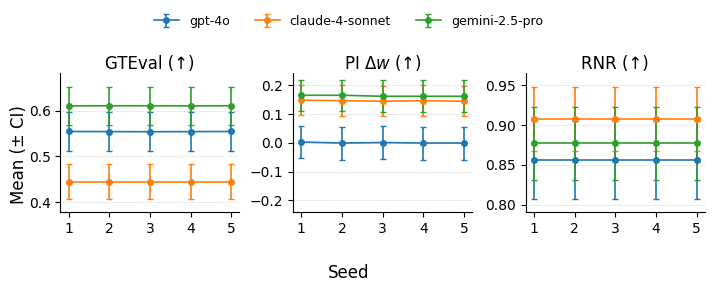

In [6]:
results = proxy_to_metric_map

proxies_order = ["gpt-4o", "claude-4-sonnet", "gemini-2.5-pro"]
metrics_order = ["GTEval (↑)", "PI $\\Delta w$ (↑)", "RNR (↑)"]
seeds_list = [1, 2, 3, 4, 5]

FIG_W, FIG_H = 7.2, 2.9
fig, axes = plt.subplots(1, 3, figsize=(FIG_W, FIG_H), sharex=True, sharey=False)

for j, metric in enumerate(metrics_order):
    ax = axes[j]

    # Collect all values to set reasonable y-limits
    all_y = []
    all_y_low = []
    all_y_high = []

    for proxy in proxies_order:
        means = np.array(results[proxy][metric]["mean"])
        cis   = np.array(results[proxy][metric]["ci"])

        if "PI" in metric:
            means = means - 0.5

        ax.errorbar(
            seeds_list, means, yerr=cis,
            fmt="o-", linewidth=1.2, markersize=4,
            capsize=2.5, label=proxy
        )

        all_y.extend(means.tolist())
        all_y_low.extend((means - cis).tolist())
        all_y_high.extend((means + cis).tolist())

    ax.set_title(metric, pad=3)
    ax.set_xticks(seeds_list)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ---- Metric-specific y scaling ----
    y_min = float(np.min(all_y_low))
    y_max = float(np.max(all_y_high))

    if "PI" in metric:
        # Symmetric around 0 (since Δw is centered), with padding
        max_abs = max(abs(y_min), abs(y_max))
        pad = 0.10 * max_abs if max_abs > 0 else 0.05
        ax.set_ylim(-(max_abs + pad), (max_abs + pad))
        # ax.axhline(0, linestyle="--", linewidth=1)  # baseline only for PI
    else:
        # Regular padding for non-centered metrics
        rng = y_max - y_min
        pad = 0.12 * rng if rng > 0 else 0.05
        ax.set_ylim(y_min - pad, y_max + pad)

    # # Hide y tick labels for middle/right panels to save space
    # if j != 0:
    #     ax.set_yticklabels([])

# Shared labels (positioned to avoid overlap)
fig.supxlabel("Seed", y=0.06)
fig.supylabel("Mean (± CI)", x=0.03)

# Legend above (clean single-column look)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9
)

fig.subplots_adjust(
    left=0.1, right=0.995,
    top=0.78, bottom=0.30,
    wspace=0.30
)

# plt.show()
plt.savefig("multiseed_1x3_singlecol_fixed_PIscale.pdf", dpi=300, bbox_inches='tight', format='pdf')
